<a href="https://colab.research.google.com/github/rayvoelker/rayvoelker.github.io/blob/master/iug2023/ray_voelker_lightning_talk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# So You Want to Sierra API?    

<div style="
            margin: auto;
            align-items: center;
            justify-content: center;
            /* For horizontal alignment */
            align-items: center;
            /* For vertical alignment   */
            ">
  <div>
  <blockquote cite="http://rayvoelker.github.io/iug2023/">
      Ray Voelker<br />
      IUG 2023 Lightning Talk<br />
      <a href="http://rayvoelker.github.io/iug2023/">http://rayvoelker.github.io/iug2023/</a><br />
      <a href="mailto:ray.voelker@chpl.org">ray.voelker@chpl.org</a><br />
  </blockquote>
  </div>  
  <img src="https://collection-analysis.cincy.pl/static/CHPL_Brandmark_Primary.png" width="300px"  />
  <img src="https://www.innovativeusers.org/wp-content/uploads/2023/01/2023logo.jpeg" width="300px" />
</div>

> I would like to get started writing a ***simple* Python script** that will use the **Sierra API** to **examine patron holds on the holdshelf** for an ***automated* report**.

**From the Sierra Documentation**

https://techdocs.iii.com/sierraapi/Content/zAuth/authAuth.htm

> The Sierra API uses uses the OAuth 2.0 authorization framework ... and supports the "client credentials grant" and "authorization code grant" flows.

## Part One: Authorization

Before you get started you'll first need to use the **Admin Corner** to create an API account that has appropriate grants, or permissions to do what you need to do. You'll be given a "**Client Key**" and "**Client Secret**"

### "Authorization" is a 2-step process. 

> 1. Your client application uses the **key**/**secret** pair to **request an *access token*** from the Sierra REST API **authorization endpoint**.

The **authorization endpoint** looks like the following:

```https://<host name>/<path>/<version>/token```

Or, for the **Cincinnati & Hamilton County Public Library**, it like this:

```https://classic.cincinnatilibrary.org/iii/sierra-api/v6/token```

> 2. Your client application extracts the access token from the response and sends the access token with each API request.

In [1]:
# 0. import modules that will be used here
import requests
import json
import time as time

# 1. Set the token endpoint URL
token_url = "https://classic.cincinnatilibrary.org/iii/sierra-api/v6/token"

# 2. Set the client ID and secret obtained from the API provider
client_id = 'PUT_YOUR_CLIENT_ID_HERE'
client_secret = 'PUT_YOUR_CLIENT_SECRET_HERE'

# ... or, better store credentials in a config file 
# (in this case from google drive)
from google.colab import drive
drive.mount('/content/drive/')
with open('/content/drive/MyDrive/iug2023/config.json', 'r') as f:
  config = json.loads(f.read())
  client_id = config['client_id']
  client_secret = config['client_secret']

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
# 3. Set up a Requests Session object
session = requests.Session()

# 4. Set the default session headers
session.headers = {
    'accept': 'application/json',
    'Authorization': '',
}
# .. and define a session cookie to track when the token expires
# (expires_at is an interger "timestamp" --seconds since UNIX Epoch
session.cookies['expires_at'] = '0'

In [3]:
# 5. Define a function to authenticate our API requests
"""
https://gist.github.com/rayvoelker/7791c50f2176ae32799edd25431fb9db
"""
def authenticate_session(session):
  """
  Function, authenticate_session() accpepts a Requests Session object, 
  and then returns the session with headers containing a token that is 
  valid to make futue requests using the token
  """
  if (
      session.headers['Authorization'] == '' 
      or float(session.cookies['expires_at']) < time.time()
  ):  
    # Set the request parameters (for authentication and
    # the grant type)
    auth = requests.auth.HTTPBasicAuth(
      username=client_id, 
      password=client_secret
    )
    data = {
      "grant_type": "client_credentials"
    }

    # Send the token request
    # **this is Authorization Step 1**
    response = session.post(url=token_url, auth=auth, data=data)

    # Check if the request was successful
    if response.status_code == 200:
      # Extract the access token and expiration time from the response
      # **this is Authorization Step 2**
      session.headers['Authorization'] = \
        'Bearer ' + response.json()['access_token']

      # pad our expiration time by -60 seconds to be safe ...
      session.cookies['expires_at'] = \
        str(time.time() + response.json()['expires_in'] - 60)
      return(session)
    else:
      # If the request failed, raise an exception
      raise Exception('Failed to obtain access token: ' + response.text)

  else:
    # session, and token are still valid 
    return session

In [4]:
# **Make an authorized request to the v6/info/token endpoint

# authticate the session (if needed)
session = authenticate_session(session)

# make the request--/v6/info/token
response = session.get(
  'https://classic.cincinnatilibrary.org/iii/sierra-api/v6/info/token'
)

print(f"""\
  response status code                  :{response.status_code}
  response json value for key expiresIn :{response.json()['expiresIn']}
  session expires at (UNIX Epoch)       :{session.cookies['expires_at']}
  time now                              :{time.time()}
  seconds left                          :{float(session.cookies['expires_at']) - time.time()}
""")

  response status code                  :200
  response json value for key expiresIn :3599
  session expires at (UNIX Epoch)       :1683303444.0616763
  time now                              :1683299904.113384
  seconds left                          :3539.94823551178



# Get the Patron Holds

There's no easy way to query holds via the API (cough..sql..cough), so we have to work through all the patron holds

`/v6/patrons/holds`

The description of this endpoint is described in the Sierra Documentation (https://techdocs.iii.com/sierraapi/Content/zAPIs/patronAPI_holds.htm#Get3):

> Returns the combined total number of bibliographic-, item-, and volume-level holds in the system and a Hold object for each hold.

> By default, this endpoint returns the first 50 results. You can limit the number of results to a value from 1 to 2000 and specify the beginning record to return. See Pagination Parameters for more information on using these limiters.

## `/v6/patrons/holds` Parameters

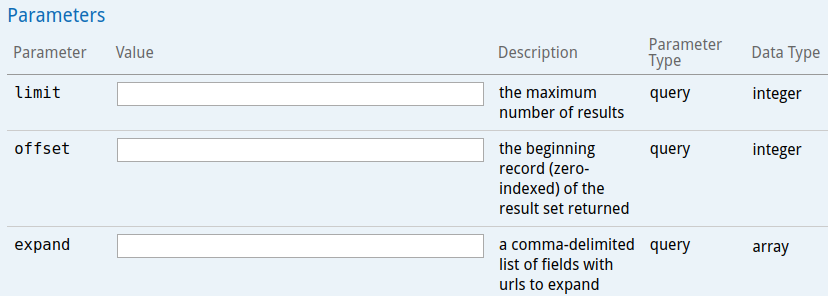

## `/v6/patrons/holds` Response Class

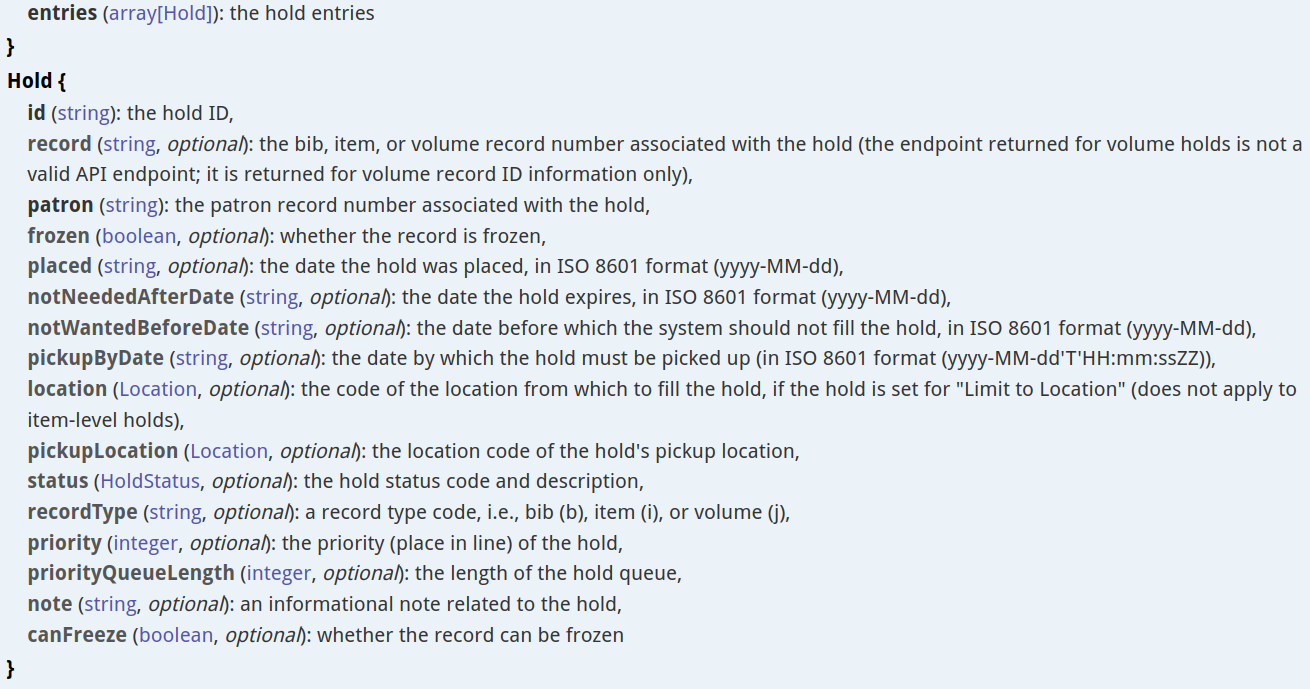

In [5]:
%%time
# get some sample holds data
session = authenticate_session(session)

"""
we can "expand" the results for the following fields, but it does 
increase the time it takes to generate the results (by a lot)
      id:  the hold information
  record:  the record that is on hold
  patron:  the patron with the hold 
"""
params = {
    'limit': 2000,
    'offset': 0,
    'expand': '' # don't expand any records
}
result = session.get(
    'https://classic.cincinnatilibrary.org/iii/sierra-api/v6/patrons/holds', 
    params=params
)

CPU times: user 36 ms, sys: 3.35 ms, total: 39.3 ms
Wall time: 4.17 s


In [6]:
# here's what a single entry looks like:
# (fetch the last one in the list)
result.json()['entries'][-1]

{'id': 'https://classic.cincinnatilibrary.org/iii/sierra-api/v6/patrons/holds/44471308',
 'record': 'https://classic.cincinnatilibrary.org/iii/sierra-api/v6/bibs/3557134',
 'patron': 'https://classic.cincinnatilibrary.org/iii/sierra-api/v6/patrons/1492858',
 'frozen': True,
 'placed': '2020-10-06',
 'pickupLocation': {'code': 'mo', 'name': 'Monfort Heights'},
 'status': {'code': '0', 'name': 'on hold.'},
 'recordType': 'b',
 'priority': 3}

In [7]:
# let's-a-go!!
# 
# start a list of the holds ready for pickup 
#  --append to as we go
holds_ready = []

# set the url of the holds endpoint
url='https://classic.cincinnatilibrary.org/iii/sierra-api/v6/patrons/holds'

# set the initial parameters to be send along with the get request
# ... update the `offset` value to get more rows
params = {
    'limit': 2000,  # everybody to the limit
    'offset': 0,    # the offset will also keep track of when to break the loop
    'expand': ''    # the expand param could be useful for more details
}

In [8]:
# work through all the holds in the system, 
while True:
    session = authenticate_session(session)
    result = session.get(url=url, params=params)

    for entry in result.json()['entries']:
        if 'pickupByDate' in entry.keys():
            holds_ready.append({
                "hold_id": entry['id'].split('/')[-1],
                'pickupLocation': entry['pickupLocation']['name'],
                "patron_record_num": entry['patron'].split('/')[-1],
                "pickupByDate": entry['pickupByDate'],
                'item_record_num': entry['record'].split('/')[-1],
            })
    # update the offset
    params['offset'] += len(result.json()['entries'])
    if params['offset'] >= result.json()['total']:
        break
        
    print('.', end='')

print(f"""
Done.
{len(holds_ready)} holds ready for pickup
""")

...............................................................
Done.
21147 holds ready for pickup



## Finally, Export our 'Holds Ready for Pickup' Data to a Report!

It is fairly easy to use the built-in python `csv` module to output our results to a file.

In [10]:
import csv

# sort our list by several keys ... 
# ( python will retain order for values that compare the same 
#    https://stackoverflow.com/a/29849371/1445279 )
holds_ready.sort(key=lambda elem: elem['pickupByDate'], reverse=True)
holds_ready.sort(key=lambda elem: elem['patron_record_num'])
holds_ready.sort(key=lambda elem: elem['pickupLocation'])

with open('/content/drive/MyDrive/iug2023/patron_holds_ready_for_pickup.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(
        [key for key in holds_ready[0].keys()]
    )
    for hold in holds_ready:
        writer.writerow(
            [value for value in hold.values()]
        )